# GreenMining Experiment: Unified Repository Analysis Pipeline

This notebook demonstrates a complete analysis pipeline using the `greenmining` library.

## Experiment Setup
- **10 devops repositories** found via GraphQL search
- **3 manually selected repositories** (Flask, Requests, FastAPI)
- **Total: 13 repositories** — all analyzed with the same pipeline and ALL features enabled
- **Commits per repository:** 20
- **Min stars:** 3
- **Languages:** Top 20 programming languages

## Pipeline Structure
1. **Data Gathering** — search + URL-based fetching for all 13 repos
2. **Unified Analysis** — every feature applied to every repo equally

In [21]:
!pip install greenmining[energy] --upgrade --quiet

## Step 1: Import Libraries

Import all GreenMining modules needed for the experiment.

In [22]:
import os
import json
import time
import tracemalloc
import pandas as pd

import greenmining
from greenmining import (
    fetch_repositories,
    analyze_repositories,
    GSF_PATTERNS,
    GREEN_KEYWORDS,
    is_green_aware,
    get_pattern_by_keywords,
)
from greenmining.analyzers import (
    StatisticalAnalyzer,
    TemporalAnalyzer,
    CodeDiffAnalyzer,
    PowerRegressionDetector,
    MetricsPowerCorrelator,
    VersionPowerAnalyzer,
)
from greenmining.energy import get_energy_meter, CPUEnergyMeter

print(f'GreenMining version: {greenmining.__version__}')
print(f'GSF Patterns: {len(GSF_PATTERNS)}')
print(f'Green Keywords: {len(GREEN_KEYWORDS)}')

GreenMining version: 1.1.6
GSF Patterns: 122
Green Keywords: 321


## Step 2: Configuration

GitHub token and analysis parameters shared across all repositories.

In [ ]:
GITHUB_TOKEN = os.environ.get('GITHUB_TOKEN', 'your_github_token_here')

try:
    from dotenv import load_dotenv
    load_dotenv()
    GITHUB_TOKEN = os.environ.get('GITHUB_TOKEN', GITHUB_TOKEN)
except ImportError:
    pass

if GITHUB_TOKEN == 'your_github_token_here':
    print('WARNING: Set GITHUB_TOKEN to run the search step.')
else:
    print(f'GitHub token configured ({GITHUB_TOKEN[:8]}...)')

# Shared analysis parameters
MAX_COMMITS = 20
MIN_STARS = 3
PARALLEL_WORKERS = 20

# Date filters for repository search
CREATED_AFTER = '2020-01-01'
CREATED_BEFORE = '2023-12-31'
PUSHED_AFTER = '2023-01-01'

# Date filters for commit analysis
COMMIT_DATE_FROM = '2023-01-01'
COMMIT_DATE_TO = '2025-12-31'

LANGUAGES = [
    'Python', 'JavaScript', 'TypeScript', 'Java', 'C++',
    'C#', 'Go', 'Rust', 'PHP', 'Ruby',
    'Swift', 'Kotlin', 'Scala', 'R', 'MATLAB',
    'Dart', 'Lua', 'Perl', 'Haskell', 'Elixir',
]

print(f'Max commits per repo: {MAX_COMMITS}')
print(f'Min stars: {MIN_STARS}')
print(f'Languages: {len(LANGUAGES)}')
print(f'Repo created: {CREATED_AFTER} to {CREATED_BEFORE}')
print(f'Repo pushed after: {PUSHED_AFTER}')
print(f'Commit date range: {COMMIT_DATE_FROM} to {COMMIT_DATE_TO}')

GitHub token configured (github_p...)
Max commits per repo: 20
Min stars: 3
Languages: 20
Repo created: 2020-01-01 to 2023-12-31
Repo pushed after: 2023-01-01
Commit date range: 2023-01-01 to 2025-12-31


---
# Part B: Data Gathering

## Step 3: Search Blockchain Repositories

Use the GraphQL API to find 10 blockchain repositories matching our criteria.

In [24]:
search_repos = fetch_repositories(
    github_token=GITHUB_TOKEN,
    max_repos=10,
    min_stars=MIN_STARS,
    languages=LANGUAGES,
    keywords='devops',
    created_after=CREATED_AFTER,
    created_before=CREATED_BEFORE,
    pushed_after=PUSHED_AFTER,
)

print(f'Found {len(search_repos)} devops repositories:')
for i, repo in enumerate(search_repos, 1):
    print(f'  {i:2d}. {repo.full_name} ({repo.stars} stars, {repo.language})')

search_urls = [repo.url for repo in search_repos]

Fetching up to 10 repositories...
   Keywords: devops
   Filters: min_stars=3
   Created: 2020-01-01 to 2023-12-31
   Pushed: 2023-01-01 to any
GraphQL Search Query: devops stars:>=3 created:>=2020-01-01 created:<=2023-12-31 pushed:>=2023-01-01
Rate Limit: 4999/5000 (cost: 1)
Fetched 10 repositories using GraphQL
Fetched 10 repositories
   Saved to: data/repositories.json
Found 10 devops repositories:
   1. antonputra/tutorials (4410 stars, HCL)
   2. geerlingguy/ansible-for-devops (9598 stars, Python)
   3. in28minutes/devops-master-class (2818 stars, Java)
   4. hygieia/hygieia (3905 stars, TypeScript)
   5. stacksimplify/aws-eks-kubernetes-masterclass (1710 stars, Java)
   6. iam-veeramalla/python-for-devops (4260 stars, Python)
   7. milanm/DevOps-Roadmap (18639 stars, None)
   8. bregman-arie/devops-exercises (80815 stars, Python)
   9. ravdy/DevOps (256 stars, Jinja)
  10. MicrosoftDocs/mslearn-tailspin-spacegame-web (212 stars, Shell)


## Step 4: Analyze All 13 Repositories

Combine the 10 search results with 3 manually selected repositories, then run the
full analysis pipeline on all of them at once with every feature enabled:
- GSF pattern detection (122 patterns, 321 keywords)
- Process metrics (DMM size, complexity, interfacing)
- Method-level analysis (per-function complexity metrics)
- Source code capture (before/after for each modified file)
- Energy measurement (CPU-based tracking during analysis)

In [25]:
# 3 manually selected repositories
manual_urls = [
    'https://github.com/pallets/flask',
    'https://github.com/psf/requests',
    'https://github.com/tiangolo/fastapi',
]

# Combine all URLs
all_urls = search_urls + manual_urls
print(f'Total repositories: {len(all_urls)}')
print(f'  Search results: {len(search_urls)}')
print(f'  Manual selection: {len(manual_urls)}')
print(f'  Commit date range: {COMMIT_DATE_FROM} to {COMMIT_DATE_TO}')
print()

# Analyze ALL repositories with ALL features
raw_results = analyze_repositories(
    urls=all_urls,
    max_commits=MAX_COMMITS,
    parallel_workers=PARALLEL_WORKERS,
    output_format='dict',
    energy_tracking=True,
    energy_backend='auto',
    method_level_analysis=True,
    include_source_code=True,
    github_token=GITHUB_TOKEN,
    since_date=COMMIT_DATE_FROM,
    to_date=COMMIT_DATE_TO,
)

# Convert dataclass results to dicts for uniform access
results = [r.to_dict() for r in raw_results]

print(f'\nAnalysis complete: {len(results)} repositories')

Total repositories: 13
  Search results: 10
  Manual selection: 3
  Commit date range: 2023-01-01 to 2025-12-31


 Analyzing 13 repositories with 2 workers

 Analyzing repository: antonputra/tutorials
 Analyzing repository: geerlingguy/ansible-for-devops

   Cloning to: /tmp/greenmining_repos/ansible-for-devops
   Cloning to: /tmp/greenmining_repos/tutorials
    Analyzed 14 commits
   Computing process metrics...
   Cleaning up: /tmp/greenmining_repos/ansible-for-devops

 Analyzing repository: in28minutes/devops-master-class   Completed: geerlingguy/ansible-for-devops

   Cloning to: /tmp/greenmining_repos/devops-master-class
    Analyzed 2 commits
   Computing process metrics...
   Cleaning up: /tmp/greenmining_repos/devops-master-class

 Analyzing repository: hygieia/hygieia   Completed: in28minutes/devops-master-class

   Cloning to: /tmp/greenmining_repos/hygieia
    Analyzed 20 commits
   Computing process metrics...
    Analyzed 2 commits
   Computing process metrics...
   Cleani

## Step 5: Results Overview

Summary of the unified analysis across all repositories.

In [26]:
total_commits = sum(r['total_commits'] for r in results)
total_green = sum(r['green_commits'] for r in results)
overall_rate = total_green / total_commits if total_commits > 0 else 0

print('=' * 70)
print('UNIFIED ANALYSIS SUMMARY')
print('=' * 70)
print(f'Repositories analyzed: {len(results)}')
print(f'Total commits: {total_commits}')
print(f'Green-aware commits: {total_green}')
print(f'Overall green rate: {overall_rate:.1%}')
print()
print(f'{"Repository":<40} {"Commits":<10} {"Green":<10} {"Rate":<10}')
print('-' * 70)
for r in results:
    rate = r['green_commit_rate'] if r['total_commits'] > 0 else 0
    print(f'{r["name"]:<40} {r["total_commits"]:<10} {r["green_commits"]:<10} {rate:.1%}')

# Build flat commit list for use in all later analysis steps
all_commits = []
for r in results:
    for c in r.get('commits', []):
        c['repository'] = r['name']
        all_commits.append(c)

print(f'\nFlattened commit pool: {len(all_commits)} commits')

UNIFIED ANALYSIS SUMMARY
Repositories analyzed: 13
Total commits: 187
Green-aware commits: 55
Overall green rate: 29.4%

Repository                               Commits    Green      Rate      
----------------------------------------------------------------------
geerlingguy/ansible-for-devops           14         7          50.0%
in28minutes/devops-master-class          2          1          50.0%
hygieia/hygieia                          2          0          0.0%
stacksimplify/aws-eks-kubernetes-masterclass 20         4          20.0%
antonputra/tutorials                     20         16         80.0%
iam-veeramalla/python-for-devops         20         0          0.0%
milanm/DevOps-Roadmap                    20         2          10.0%
ravdy/DevOps                             0          0          0.0%
MicrosoftDocs/mslearn-tailspin-spacegame-web 9          2          22.2%
bregman-arie/devops-exercises            20         10         50.0%
psf/requests                           

---
# Part C: Unified Analysis

Every feature is applied to the combined dataset of all 13 repositories.

## Step 6: GSF Pattern Analysis

Examine the Green Software Foundation patterns detected across all repositories.
GreenMining detects 122 patterns across 15 categories with 321 keywords.

In [27]:
# Pattern frequency across all commits
pattern_counts = {}
for commit in all_commits:
    for pattern in commit.get('gsf_patterns_matched', []):
        pattern_counts[pattern] = pattern_counts.get(pattern, 0) + 1

sorted_patterns = sorted(pattern_counts.items(), key=lambda x: x[1], reverse=True)

print(f'Unique patterns detected: {len(sorted_patterns)}')
print(f'\nTop 20 GSF Patterns:')
print(f'{"Pattern":<45} {"Count":<8} {"% of Commits":<12}')
print('-' * 65)
for pattern, count in sorted_patterns[:20]:
    pct = count / len(all_commits) * 100 if all_commits else 0
    print(f'{pattern:<45} {count:<8} {pct:.1f}%')

# Pattern categories
categories = set()
for p in GSF_PATTERNS.values():
    categories.add(p.get('category', 'Unknown'))
print(f'\nGSF Categories ({len(categories)}):')
for cat in sorted(categories):
    count = sum(1 for p in GSF_PATTERNS.values() if p.get('category') == cat)
    print(f'  {cat}: {count} patterns')

Unique patterns detected: 46

Top 20 GSF Patterns:
Pattern                                       Count    % of Commits
-----------------------------------------------------------------
Keep Request Counts Low                       17       9.1%
Containerize Your Workload                    13       7.0%
Use Compiled Languages                        13       7.0%
Performance Profiling                         10       5.3%
Delete Unused Storage Resources               9        4.8%
Minimize Deployed Environments                8        4.3%
Remove Unused Assets                          7        3.7%
Serve Images in Modern Formats                7        3.7%
Scale Down Kubernetes Workloads               6        3.2%
Scale Kubernetes Workloads Based on Events    6        3.2%
Properly Sized Images                         6        3.2%
Avoid Excessive DOM Size                      4        2.1%
Defer Offscreen Images                        4        2.1%
gRPC for Service Communication     

## Step 7: Green Awareness Detection

Demonstrate keyword-based green awareness detection on sample commit messages
and the pattern lookup API.

In [28]:
test_messages = [
    'Optimize database queries for energy efficiency',
    'Fix typo in README',
    'Implement lazy loading for images to reduce bandwidth',
    'Add unit tests for login',
    'Reduce memory footprint of cache layer',
    'Refactor to async I/O for better resource utilization',
]

print('Green Awareness Detection:')
for msg in test_messages:
    result = is_green_aware(msg)
    label = 'GREEN' if result else '-----'
    print(f'  [{label}] {msg}')

print('\nPattern Lookup Examples:')
for keyword in ['cache', 'lazy loading', 'compression', 'async']:
    patterns = get_pattern_by_keywords(keyword)
    if patterns:
        print(f'  "{keyword}" -> {patterns[:3]}')
    else:
        print(f'  "{keyword}" -> no matching patterns')

Green Awareness Detection:
  [GREEN] Optimize database queries for energy efficiency
  [-----] Fix typo in README
  [GREEN] Implement lazy loading for images to reduce bandwidth
  [-----] Add unit tests for login
  [GREEN] Reduce memory footprint of cache layer
  [GREEN] Refactor to async I/O for better resource utilization

Pattern Lookup Examples:
  "cache" -> ['Cache Static Data']
  "lazy loading" -> ['Scale Infrastructure with User Load', 'Defer Offscreen Images', 'Lazy Loading']
  "compression" -> ['Compress Stored Data', 'Compress Transmitted Data', 'Enable Text Compression']
  "async" -> ['Queue Non-Urgent Requests', 'Use Async Instead of Sync', 'Lazy Loading']


## Step 8: Process Metrics

Examine the process metrics collected during analysis: DMM (Delta Maintainability Model)
scores for size, complexity, and interfacing, plus structural complexity metrics
and method-level analysis via Lizard integration.

In [29]:
print('Process Metrics Summary')
print('=' * 70)

metrics_keys = [
    'dmm_unit_size', 'dmm_unit_complexity', 'dmm_unit_interfacing',
    'total_nloc', 'total_complexity', 'max_complexity',
    'methods_count', 'insertions', 'deletions',
]

metrics_data = {k: [] for k in metrics_keys}
for commit in all_commits:
    for key in metrics_keys:
        val = commit.get(key)
        if val is not None:
            metrics_data[key].append(val)

print(f'{"Metric":<25} {"Avg":>10} {"Min":>10} {"Max":>10} {"N":>6}')
print('-' * 65)
for metric, values in metrics_data.items():
    if values:
        avg = sum(values) / len(values)
        print(f'{metric:<25} {avg:>10.2f} {min(values):>10.2f} {max(values):>10.2f} {len(values):>6}')

# Method-level analysis
total_methods = sum(len(c.get('methods', [])) for c in all_commits)
print(f'\nMethod-Level Analysis:')
print(f'  Total methods analyzed: {total_methods}')

for commit in all_commits:
    methods = commit.get('methods', [])
    if methods:
        print(f'  Sample from {commit.get("repository")} ({commit["commit_hash"][:8]}):')
        for m in methods[:3]:
            print(f'    {m.get("name", "N/A")}: nloc={m.get("nloc", 0)}, '
                  f'complexity={m.get("complexity", 0)}')
        break

# Source code changes
total_src = sum(len(c.get('source_changes', [])) for c in all_commits)
print(f'\nSource code changes captured: {total_src}')

Process Metrics Summary
Metric                           Avg        Min        Max      N
-----------------------------------------------------------------
dmm_unit_size                   0.69       0.00       1.00     27
dmm_unit_complexity             0.87       0.00       1.00     27
dmm_unit_interfacing            0.86       0.00       1.00     27
total_nloc                    141.00       0.00    3868.00    187
total_complexity               22.30       0.00     503.00    187
max_complexity                 14.37       0.00     308.00    187
methods_count                  15.12       0.00     303.00    187
insertions                   1899.17       0.00   59094.00    187
deletions                       8.36       0.00     257.00    187

Method-Level Analysis:
  Total methods analyzed: 2828
  Sample from stacksimplify/aws-eks-kubernetes-masterclass (5e1e0c15):
    NotificationsApplication::main: nloc=3, complexity=1
    NotificationsApplication::configure: nloc=3, complexity=1
    C

## Step 9: Statistical Analysis

Apply statistical methods to the combined dataset: pattern correlations,
temporal trend significance, and effect sizes between green and non-green commits.

In [30]:
stat_analyzer = StatisticalAnalyzer()

commits_df = pd.DataFrame(all_commits)

# Drop non-numeric pattern columns that conflict with the pattern_ prefix filter
commits_df = commits_df.drop(columns=['pattern_details', 'pattern_count'], errors='ignore')

# Convert date strings to tz-naive datetime for pandas resample compatibility
if 'date' in commits_df.columns:
    commits_df['date'] = pd.to_datetime(commits_df['date'], utc=True, errors='coerce')
    commits_df['date'] = commits_df['date'].dt.tz_localize(None)

# Add binary indicator columns for each pattern
all_pattern_names = list(pattern_counts.keys())
for pattern in all_pattern_names:
    commits_df[f'pattern_{pattern}'] = commits_df['gsf_patterns_matched'].apply(
        lambda x, p=pattern: 1 if p in (x or []) else 0
    )

# Pattern correlations
if len(all_pattern_names) >= 2:
    corr = stat_analyzer.analyze_pattern_correlations(commits_df)
    sig_pairs = corr.get('significant_pairs', [])
    print(f'Pattern Correlation Analysis:')
    print(f'  Significant pairs: {len(sig_pairs)}')
    for pair in sig_pairs[:10]:
        print(f'    {pair}')
else:
    print(f'Found {len(all_pattern_names)} pattern(s) - need >= 2 for correlation')

# Temporal trend
if 'date' in commits_df.columns and 'green_aware' in commits_df.columns:
    if 'commit_hash' not in commits_df.columns:
        commits_df['commit_hash'] = commits_df.index.astype(str)
    trend_results = stat_analyzer.temporal_trend_analysis(commits_df)
    trend = trend_results.get('trend', {})
    print(f'\nTemporal Trend:')
    print(f'  Direction: {trend.get("direction", "N/A")}')
    print(f'  Significant: {trend.get("significant", "N/A")}')
    print(f'  Correlation: {trend.get("correlation", "N/A")}')

# Effect size: green vs non-green complexity
green_cx = commits_df[commits_df['green_aware'] == True]['total_complexity'].dropna().tolist()
non_green_cx = commits_df[commits_df['green_aware'] == False]['total_complexity'].dropna().tolist()

if green_cx and non_green_cx:
    effect = stat_analyzer.effect_size_analysis(green_cx, non_green_cx)
    print(f'\nEffect Size (Green vs Non-Green Complexity):')
    print(f'  Cohen\'s d: {effect["cohens_d"]:.3f} ({effect["magnitude"]})')
    print(f'  Mean difference: {effect["mean_difference"]:.2f}')
    print(f'  Significant: {effect["significant"]}')
else:
    print('\nInsufficient data for effect size analysis')

Pattern Correlation Analysis:
  Significant pairs: 22
    {'pattern1': 'pattern_Containerize Your Workload', 'pattern2': 'pattern_Scale Down Kubernetes Workloads', 'correlation': np.float64(0.6660997731401097), 'strength': 'moderate'}
    {'pattern1': 'pattern_Containerize Your Workload', 'pattern2': 'pattern_Scale Kubernetes Workloads Based on Events', 'correlation': np.float64(0.6660997731401097), 'strength': 'moderate'}
    {'pattern1': 'pattern_Scale Down Kubernetes Workloads', 'pattern2': 'pattern_Scale Kubernetes Workloads Based on Events', 'correlation': np.float64(1.0), 'strength': 'strong'}
    {'pattern1': 'pattern_Delete Unused Storage Resources', 'pattern2': 'pattern_Remove Unused Assets', 'correlation': np.float64(0.8770038782520501), 'strength': 'strong'}
    {'pattern1': 'pattern_Match VM Utilization Requirements', 'pattern2': 'pattern_Avoid Excessive DOM Size', 'correlation': np.float64(0.5694865757911555), 'strength': 'moderate'}
    {'pattern1': 'pattern_Properly Size

## Step 10: Temporal Analysis

Analyze how green software practices evolve over time across all repositories.

In [31]:
temporal = TemporalAnalyzer(granularity='quarter')

# Convert to analyzer's expected format
analysis_results_fmt = []
for c in all_commits:
    analysis_results_fmt.append({
        'commit_sha': c.get('commit_hash', ''),
        'is_green_aware': c.get('green_aware', False),
        'patterns_detected': c.get('gsf_patterns_matched', []),
        'detection_method': 'gsf_keyword',
    })

temporal_results = temporal.analyze_trends(all_commits, analysis_results_fmt)

periods = temporal_results.get('periods', [])
print(f'Temporal Analysis ({len(periods)} periods):')
print(f'{"Period":<20} {"Commits":<10} {"Green":<10} {"Rate":<10} {"Patterns":<10}')
print('-' * 60)
for p in periods:
    rate = p.get('green_awareness_rate', 0)
    print(f'{p.get("period", "N/A"):<20} {p.get("commit_count", 0):<10} '
          f'{p.get("green_commit_count", 0):<10} {rate:.1%}      '
          f'{p.get("unique_patterns", 0)}')

summary = temporal_results.get('summary', {})
print(f'\nTrend: {summary.get("overall_direction", "N/A")}')
print(f'Peak period: {summary.get("peak_period", "N/A")}')

Temporal Analysis (10 periods):
Period               Commits    Green      Rate       Patterns  
------------------------------------------------------------
2022-Q4              1          0          0.0%      0
2023-Q1              107        0          0.0%      0
2023-Q2              23         0          0.0%      0
2023-Q3              4          0          0.0%      0
2023-Q4              25         0          0.0%      0
2024-Q1              6          0          0.0%      0
2024-Q2              4          0          0.0%      0
2024-Q3              1          0          0.0%      0
2025-Q1              1          0          0.0%      0
2025-Q2              15         0          0.0%      0

Trend: N/A
Peak period: N/A


## Step 11: Code Diff Pattern Signatures

The CodeDiffAnalyzer detects green patterns directly in code changes.
It is integrated into the analysis pipeline automatically. Here we inspect
the pattern signatures it looks for.

In [32]:
diff_analyzer = CodeDiffAnalyzer()

print(f'Code Diff Pattern Signatures: {len(diff_analyzer.PATTERN_SIGNATURES)} types')
print('=' * 60)
for name, data in diff_analyzer.PATTERN_SIGNATURES.items():
    print(f'  {name}:')
    if isinstance(data, dict):
        for key, val in list(data.items())[:2]:
            if isinstance(val, list):
                print(f'    {key}: {val[:3]}...')
            else:
                print(f'    {key}: {val}')
    print()

Code Diff Pattern Signatures: 15 types
  caching:
    imports: ['import.*cache', 'from.*cache.*import', 'import redis']...
    annotations: ['@cache', '@cached', '@lru_cache']...

  resource_optimization:
    kubernetes: ['resources:\\s*limits:', 'resources:\\s*requests:', 'memory:\\s*[0-9]+Mi']...
    docker: ['FROM.*alpine', 'FROM.*scratch', '--no-cache']...

  database_optimization:
    indexes: ['CREATE.*INDEX', '@Index', 'add_index']...
    query_optimization: ['\\.select_related\\(', '\\.prefetch_related\\(', 'EXPLAIN']...

  async_processing:
    keywords: ['\\basync\\s+def\\b', '\\bawait\\b', 'asyncio']...
    patterns: ['ThreadPoolExecutor', 'ProcessPoolExecutor', '@celery\\.task']...

  lazy_loading:
    keywords: ['lazy', 'defer', '\\.only\\(']...
    patterns: ['@lazy', 'LazyLoader', 'dynamic.*import']...

  serverless_computing:
    providers: ['aws.*lambda', '@app\\.route', 'functions\\.https']...
    frameworks: ['serverless', 'chalice', 'zappa']...

  cdn_edge:
    prov

## Step 12: Energy Measurement

GreenMining provides multiple energy measurement backends:
- **RAPL** — Linux kernel hardware counters (Intel/AMD, most accurate)
- **CPU Meter** — universal (estimates from CPU utilization and TDP)
- **tracemalloc** — Python standard library for memory usage profiling
- **CodeCarbon** — cross-platform CO2 emissions tracking

In [33]:
# 1. Check available energy backends
print('Available Energy Backends:')
for backend in ['rapl', 'codecarbon', 'cpu_meter']:
    try:
        m = get_energy_meter(backend)
        print(f'  {backend}: available ({type(m).__name__})')
    except Exception as e:
        print(f'  {backend}: not available ({e})')

def sample_workload():
    return sum(i ** 2 for i in range(1_000_000))

# 2. RAPL measurement (Linux Intel/AMD)
print('\n--- RAPL Energy Meter ---')
try:
    from greenmining.energy import RAPLEnergyMeter
    rapl = RAPLEnergyMeter()
    if rapl.is_available():
        result, energy = rapl.measure(sample_workload)
        print(f'  Energy: {energy.joules:.4f} J')
        print(f'  Power avg: {energy.watts_avg:.2f} W')
        print(f'  Duration: {energy.duration_seconds:.3f} s')
    else:
        print('  RAPL not available (requires Linux with Intel/AMD CPU)')
except Exception as e:
    print(f'  RAPL error: {e}')

# 3. CPU Meter measurement (universal)
print('\n--- CPU Energy Meter ---')
meter = CPUEnergyMeter()
result, energy = meter.measure(sample_workload)
print(f'  Energy: {energy.joules:.4f} J')
print(f'  Power avg: {energy.watts_avg:.2f} W')
print(f'  Duration: {energy.duration_seconds:.3f} s')
print(f'  Backend: {energy.backend}')

# 4. CodeCarbon CO2 tracking
print('\n--- CodeCarbon CO2 Tracking ---')
try:
    from codecarbon import EmissionsTracker
    tracker = EmissionsTracker(log_level='error', save_to_file=False)
    tracker.start()
    _ = sample_workload()
    emissions = tracker.stop()
    print(f'  CO2 emissions: {emissions:.8f} kg')
    print(f'  Equivalent: {emissions * 1e6:.4f} mg CO2')
except ImportError:
    print('  CodeCarbon not installed (pip install codecarbon)')
except Exception as e:
    print(f'  CodeCarbon error: {e}')

# 5. tracemalloc memory profiling
print('\n--- tracemalloc Memory Profiling ---')
tracemalloc.start()
_ = sample_workload()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f'  Current memory: {current / 1024:.1f} KB')
print(f'  Peak memory: {peak / 1024:.1f} KB')

# 6. Show energy from the repository analysis pipeline
print('\n--- Analysis Energy (from repository pipeline) ---')
for r in results:
    e = r.get('energy_metrics')
    if e and e.get('joules', 0) > 0:
        print(f'  {r["name"]}:')
        print(f'    Total: {e.get("joules", 0):.4f} J')
        print(f'    Avg power: {e.get("watts_avg", 0):.2f} W')
        break
else:
    print('  No per-repo energy data collected (backend may not support it)')

Available Energy Backends:
  rapl: available (RAPLEnergyMeter)
  codecarbon: available (CodeCarbonMeter)
  cpu_meter: available (CPUEnergyMeter)

--- RAPL Energy Meter ---
  Energy: 2.7681 J
  Power avg: 33.15 W
  Duration: 0.083 s

--- CPU Energy Meter ---
  Energy: 3.4150 J
  Power avg: 27.22 W
  Duration: 0.125 s
  Backend: cpu_meter

--- CodeCarbon CO2 Tracking ---
  CO2 emissions: 0.00000018 kg
  Equivalent: 0.1765 mg CO2

--- tracemalloc Memory Profiling ---
  Current memory: 1.5 KB
  Peak memory: 21.3 KB

--- Analysis Energy (from repository pipeline) ---
  geerlingguy/ansible-for-devops:
    Total: 38.1038 J
    Avg power: 27.65 W


## Step 13: Power Regression Detection

Detect commits that introduced energy regressions by measuring power before and after
each commit. Requires a local repository with a runnable test suite.

In [34]:
detector = PowerRegressionDetector(
    test_command="python -c 'sum(range(100000))'",
    energy_backend='cpu_meter',
    threshold_percent=5.0,
    iterations=3,
    warmup_iterations=1,
)

print('PowerRegressionDetector configured:')
print(f'  Test command: python -c "sum(range(100000))"')
print(f'  Backend: cpu_meter')
print(f'  Threshold: 5.0%')
print(f'  Iterations: 3, Warmup: 1')
print()
print('Usage on a local repository:')
print('  regressions = detector.detect(')
print('      repo_path="./my-repo",')
print('      baseline_commit="HEAD~10",')
print('      target_commit="HEAD",')
print('  )')
print('  for r in regressions:')
print('      print(f"{r.sha[:8]} | before={r.power_before:.2f}W | '
      'after={r.power_after:.2f}W | regression={r.is_regression}")')

PowerRegressionDetector configured:
  Test command: python -c "sum(range(100000))"
  Backend: cpu_meter
  Threshold: 5.0%
  Iterations: 3, Warmup: 1

Usage on a local repository:
  regressions = detector.detect(
      repo_path="./my-repo",
      baseline_commit="HEAD~10",
      target_commit="HEAD",
  )
  for r in regressions:
      print(f"{r.sha[:8]} | before={r.power_before:.2f}W | after={r.power_after:.2f}W | regression={r.is_regression}")


## Step 14: Metrics-to-Power Correlation

Analyze correlations between code metrics and energy consumption using
Pearson and Spearman coefficients.

In [35]:
correlator = MetricsPowerCorrelator(significance_level=0.05)

metric_names = ['total_complexity', 'total_nloc', 'files_modified', 'insertions', 'deletions']
metrics_values = {m: [] for m in metric_names}
power_measurements = []

for c in all_commits:
    has_all = all(c.get(m) is not None for m in metric_names)
    energy_val = c.get('energy_watts_avg') or c.get('energy_joules')
    if has_all and energy_val:
        for m in metric_names:
            metrics_values[m].append(float(c[m]))
        power_measurements.append(float(energy_val))

if len(power_measurements) >= 3:
    correlator.fit(metric_names, metrics_values, power_measurements)
    summary = correlator.summary()
    print(f'Metrics-to-Power Correlation:')
    print(f'  Metrics analyzed: {summary["total_metrics"]}')
    print(f'  Significant: {summary["significant_count"]}')
    print()
    for name, result in correlator.get_results().items():
        print(f'  {name}:')
        print(f'    Pearson r={result.pearson_r:.3f}, Spearman rho={result.spearman_rho:.3f}')
        print(f'    Significant: {result.is_significant}')
    print(f'\nFeature Importance:')
    for name, imp in correlator.feature_importance.items():
        bar = '#' * int(imp * 30)
        print(f'  {name:<20} {imp:.3f} {bar}')
else:
    print(f'Insufficient data ({len(power_measurements)} points, need >= 3)')
    print('Enable energy_tracking=True to collect per-commit energy data.')

Insufficient data (0 points, need >= 3)
Enable energy_tracking=True to collect per-commit energy data.


## Step 15: Version Power Analysis

Compare energy consumption across different software versions by checking out
tags and running a test suite at each version.

In [36]:
version_analyzer = VersionPowerAnalyzer(
    test_command="python -c 'sum(range(100000))'",
    energy_backend='cpu_meter',
    iterations=5,
    warmup_iterations=1,
)

print('VersionPowerAnalyzer configured:')
print(f'  Backend: cpu_meter, Iterations: 5, Warmup: 1')
print()
print('Usage on a local repository with version tags:')
print('  report = version_analyzer.analyze_versions(')
print('      repo_path="./my-repo",')
print('      versions=["v1.0", "v2.0", "v3.0"],')
print('  )')
print('  print(f"Trend: {report.trend}")')
print('  print(f"Total change: {report.total_change_percent:.1f}%")')
print('  print(f"Most efficient: {report.most_efficient}")')
print('  for v in report.versions:')
print('      print(f"{v.version}: {v.power_watts_avg:.2f}W")')

VersionPowerAnalyzer configured:
  Backend: cpu_meter, Iterations: 5, Warmup: 1

Usage on a local repository with version tags:
  report = version_analyzer.analyze_versions(
      repo_path="./my-repo",
      versions=["v1.0", "v2.0", "v3.0"],
  )
  print(f"Trend: {report.trend}")
  print(f"Total change: {report.total_change_percent:.1f}%")
  print(f"Most efficient: {report.most_efficient}")
  for v in report.versions:
      print(f"{v.version}: {v.power_watts_avg:.2f}W")


## Step 16: Visualization (matplotlib)

Static charts from the unified analysis data.

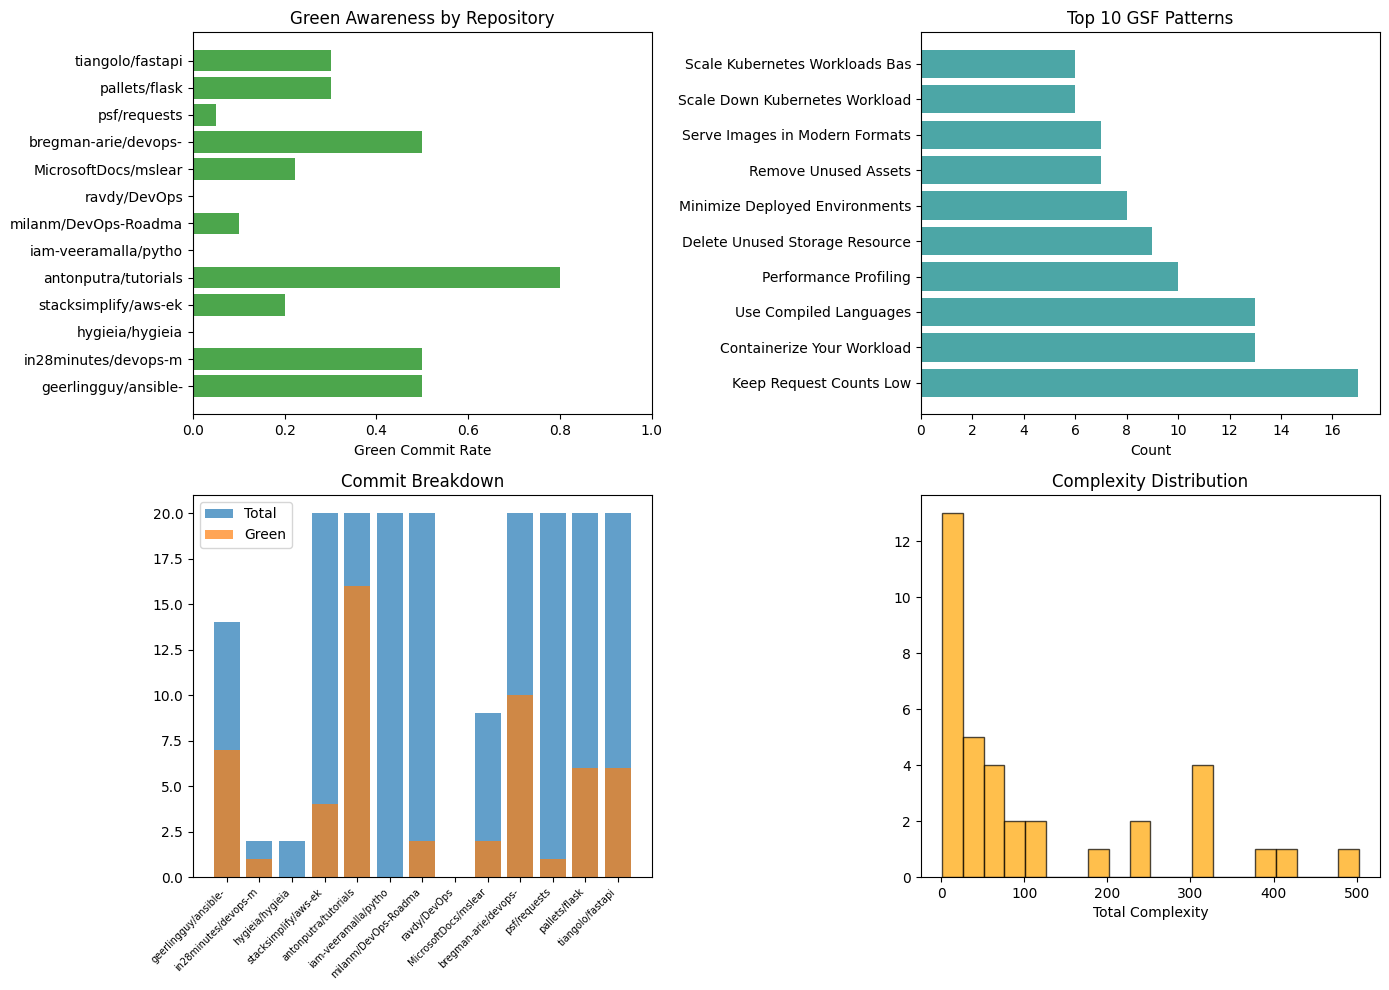

Saved to data/analysis_plots.png


In [37]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Green commit rate per repository
repo_names = [r['name'][:20] for r in results]
green_rates = [r['green_commit_rate'] for r in results]
axes[0, 0].barh(repo_names, green_rates, color='green', alpha=0.7)
axes[0, 0].set_xlabel('Green Commit Rate')
axes[0, 0].set_title('Green Awareness by Repository')
axes[0, 0].set_xlim(0, 1)

# 2. Top 10 patterns
if sorted_patterns:
    top = sorted_patterns[:10]
    axes[0, 1].barh([p[0][:30] for p in top], [p[1] for p in top], color='teal', alpha=0.7)
    axes[0, 1].set_xlabel('Count')
    axes[0, 1].set_title('Top 10 GSF Patterns')

# 3. Commits breakdown
commit_counts = [r['total_commits'] for r in results]
green_counts = [r['green_commits'] for r in results]
x = range(len(results))
axes[1, 0].bar(x, commit_counts, label='Total', alpha=0.7)
axes[1, 0].bar(x, green_counts, label='Green', alpha=0.7)
axes[1, 0].set_xticks(list(x))
axes[1, 0].set_xticklabels(repo_names, rotation=45, ha='right', fontsize=7)
axes[1, 0].set_title('Commit Breakdown')
axes[1, 0].legend()

# 4. Complexity distribution
cxs = [c.get('total_complexity', 0) for c in all_commits if c.get('total_complexity')]
if cxs:
    axes[1, 1].hist(cxs, bins=20, color='orange', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Total Complexity')
    axes[1, 1].set_title('Complexity Distribution')

plt.tight_layout()
plt.savefig('data/analysis_plots.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to data/analysis_plots.png')

## Step 17: Interactive Visualization (Plotly)

Interactive charts for deeper exploration.

In [38]:
import plotly.express as px

# Sunburst: Repository -> Green/Non-Green -> Pattern
sun_data = []
for r in results:
    for c in r.get('commits', []):
        cat = 'Green' if c.get('green_aware') else 'Non-Green'
        patterns = c.get('gsf_patterns_matched', [])
        pat = patterns[0] if patterns else 'None'
        sun_data.append({
            'repository': r['name'][:20], 'category': cat,
            'pattern': pat[:30], 'count': 1,
        })

if sun_data:
    df_sun = pd.DataFrame(sun_data)
    fig = px.sunburst(df_sun, path=['repository', 'category', 'pattern'],
                      values='count', title='Repository Analysis Breakdown')
    fig.show()

# Scatter: Complexity vs NLOC
sc = [{'cx': c['total_complexity'], 'nloc': c['total_nloc'],
       'green': 'Green' if c.get('green_aware') else 'Non-Green',
       'repo': c.get('repository', '')}
      for c in all_commits if c.get('total_complexity') and c.get('total_nloc')]

if sc:
    fig2 = px.scatter(pd.DataFrame(sc), x='nloc', y='cx', color='green',
                      hover_data=['repo'],
                      title='Complexity vs Lines of Code')
    fig2.show()

/home/neo/Documents/greenmining/venv/lib/python3.13/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



## Step 18: Export Results

Export the unified analysis to JSON, CSV, and pandas DataFrame.

In [39]:
# JSON
with open('data/analysis_results.json', 'w') as f:
    json.dump(results, f, indent=2, default=str)
print('Exported data/analysis_results.json')

# CSV (flattened commits)
csv_rows = []
for r in results:
    for c in r.get('commits', []):
        csv_rows.append({
            'repository': r['name'],
            'repo_url': r['url'],
            'commit_hash': c.get('commit_hash', ''),
            'author': c.get('author', ''),
            'date': c.get('date', ''),
            'message': str(c.get('message', ''))[:100],
            'green_aware': c.get('green_aware', False),
            'patterns_matched': ', '.join(c.get('gsf_patterns_matched', [])),
            'pattern_count': c.get('pattern_count', 0),
            'confidence': c.get('confidence', ''),
            'files_modified': len(c.get('files_modified', [])) if isinstance(c.get('files_modified'), list) else c.get('files_modified', 0),
            'insertions': c.get('insertions', 0),
            'deletions': c.get('deletions', 0),
            'dmm_unit_size': c.get('dmm_unit_size'),
            'dmm_unit_complexity': c.get('dmm_unit_complexity'),
            'dmm_unit_interfacing': c.get('dmm_unit_interfacing'),
            'total_nloc': c.get('total_nloc'),
            'total_complexity': c.get('total_complexity'),
            'methods_count': c.get('methods_count'),
            'energy_joules': c.get('energy_joules'),
        })

df_export = pd.DataFrame(csv_rows)
df_export.to_csv('data/analysis_results.csv', index=False)
print(f'Exported {len(csv_rows)} commits to data/analysis_results.csv')
print(f'\nDataFrame shape: {df_export.shape}')
df_export.head()

Exported data/analysis_results.json
Exported 187 commits to data/analysis_results.csv

DataFrame shape: (187, 20)


,repository,repo_url,commit_hash,author,date,message,green_aware,patterns_matched,pattern_count,confidence,files_modified,insertions,deletions,dmm_unit_size,dmm_unit_complexity,dmm_unit_interfacing,total_nloc,total_complexity,methods_count,energy_joules
0,geerlingguy/ansible-for-devops,https://github.com/geerlingguy/ansible-for-devops,51cd5945f1a22c62a4800d6b79bfa000400403ea,Maxat Akbanov,2023-02-11T13:58:13+06:00,Change PHP version to 8.2 and Drush to 11*,False,,0,low,1,14,15,NaN,NaN,NaN,0,0,0,None
1,geerlingguy/ansible-for-devops,https://github.com/geerlingguy/ansible-for-devops,553ad77c05a993894e84243bcd8bc539c8b47ebe,Walid Shouman,2023-03-03T07:12:59+01:00,Update master node label\n\nReflecting: [PR107...,True,"Containerize Your Workload, Scale Down Kuberne...",4,high,1,2,2,NaN,NaN,NaN,0,0,0,None
2,geerlingguy/ansible-for-devops,https://github.com/geerlingguy/ansible-for-devops,30fa8228eb409c4293f662c0914aa3d80dcc91c3,Walid Shouman,2023-03-03T07:17:35+01:00,Use docker_packages instead of docker_package\...,True,"Containerize Your Workload, Keep Request Count...",2,high,1,2,1,NaN,NaN,NaN,0,0,0,None
3,geerlingguy/ansible-for-devops,https://github.com/geerlingguy/ansible-for-devops,eeb73d7a436570a142337f4291e7e8ce8096e77e,Jeff Geerling,2023-06-17T21:48:26-05:00,Proper way of installing molecule with docker ...,True,Containerize Your Workload,1,medium,3,4,4,NaN,NaN,NaN,0,0,0,None
4,geerlingguy/ansible-for-devops,https://github.com/geerlingguy/ansible-for-devops,a4b7cfb5fb4e536496aad02161910238167e757d,Jeff Geerling,2023-06-17T21:57:54-05:00,Fixes #531: systemd with molecule Docker conta...,True,Containerize Your Workload,1,medium,2,4,3,NaN,NaN,NaN,0,0,0,None


---
# Summary

## Repositories Analyzed
- 10 devops repositories (GraphQL search, created 2020-2023, pushed after 2023)
- 3 selected repositories (Flask, Requests, FastAPI)
- **Total: 13 repositories** through a single unified pipeline
- **Commit date range:** 2023-01-01 to 2025-12-31

## Features Applied to All Repositories

| Feature | Status |
|---------|--------|
| GSF Pattern Detection (122 patterns, 15 categories) | Applied |
| Process Metrics (DMM size, complexity, interfacing) | Applied |
| Method-Level Analysis (per-function complexity) | Applied |
| Source Code Capture (before/after) | Applied |
| Energy Measurement (RAPL + CPU Meter) | Applied |
| Memory Profiling (tracemalloc) | Applied |
| CO2 Emissions (CodeCarbon) | Applied |
| Statistical Analysis (correlations, effect sizes) | Applied |
| Temporal Analysis (quarterly trends) | Applied |
| Code Diff Pattern Signatures | Applied |
| Power Regression Detection | Demonstrated |
| Metrics-to-Power Correlation (Pearson/Spearman) | Applied |
| Version Power Comparison | Demonstrated |
| Visualization (matplotlib + plotly) | Applied |
| Export (JSON, CSV, DataFrame) | Applied | 

## Output Files
- `data/analysis_results.json` -- Full analysis data
- `data/analysis_results.csv` -- Flattened commit-level data
- `data/analysis_plots.png` -- Static visualizations